# **xgboost_timeseries_modeling_template**

---

<br><br><br><br>

## **Variable Inputs**
---

In [105]:
input_file_path = ''

## **Todo List**

- TODO: more structure around the naming of dataframes in different steps of the process:2023-03-07

- TODO: abstract certain functions into fp-data-toolbox :2023-03-07

<br>


# **Environment Setup**

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
# custom imports
# general eda functions and win toast notifier on cell completion
from fp_data_toolbox import eda, notifier, environment
# Magics env settings...
# Setup sqlalchemy connection url for MSSQL Server connection here
%matplotlib inline
# env setup functions
notifier.setup()  # Enable for windows toast notifications on Jupyter cell complete
# Enable to setup a ydata_profiling config.yaml file in the parent project
yaml_config_path = environment.ydata_yaml_setup()
# env variables
df = pd.DataFrame()    # creating empty dataframe variable
params = {}            # creating empty parameters dictionary
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
import warnings
warnings.filterwarnings('ignore')

<br><br>

## **Objectives**

---

example of XGBoost ML timeseries prediction pipeline

<br><br>

### **Visualizing ETL pipeline (example)**

In [107]:
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()
color_pal

[(0.0, 0.5607843137254902, 0.8352941176470589),
 (0.9882352941176471, 0.30980392156862746, 0.18823529411764706),
 (0.8980392156862745, 0.6823529411764706, 0.2196078431372549),
 (0.42745098039215684, 0.5647058823529412, 0.30980392156862746),
 (0.5450980392156862, 0.5450980392156862, 0.5450980392156862),
 (0.5058823529411764, 0.058823529411764705, 0.48627450980392156)]


## **Function Definition**



### **Data Cleaning**


In [108]:
def replace_with_null(df):
    for col in df.columns:
        if df[col].dtype.name == 'category':
            df[col] = df[col].replace([-1, 0, 'UNK', 'NULL', 'NaN'], np.nan)
        if df[col].dtype.name == 'object':
            df[col] = df[col].replace([-1, 0, 'UNK', 'NULL', 'NaN'], np.nan)
        if df[col].dtype.name == 'float64':
            df[col] = df[col].replace([-1, 0, 'UNK', 'NULL', 'NaN'], np.nan)
    return df


## **Query Data**


In [109]:
from fredapi import Fred
# pass in fred api key
fred_key = 'ed0a736bb61e29e91648917fec70e2e6'

### 1. Create the FRED object

In [110]:
fred = Fred(api_key=fred_key)

### 2. Search Fred
- for economic data

In [111]:
# fred_search_prompt = 'unemployment rate state'
# fred_search_results = fred.search(
#     fred_search_prompt, 
#     filter=('frequency', 'Monthly'),
#     order_by='popularity'
#     )
# fred_search_results = fred_search_results.query(
#     'seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"'
#     )
# fred_search_results = fred_search_results.loc[fred_search_results['title'].str.contains('Unemployment Rate')]

# fred_search_results.head()

<br><br><br>

### **Pull raw data**

In [112]:
# df_sp = fred.get_series('SP500')
# df_sp.plot(figsize=(10,5), title = 'S&P 500', lw=2)

In [113]:
# unemployment_results = fred.search('unemployment', order_by='popularity')
# unemployment_results.head()

In [114]:
# df_unrate = fred.get_series('UNRATE')
# df_unrate.plot(figsize=(10,5), title = 'Unemployment Rate', lw=2)

### 4. Pull and join multiple data series

In [115]:
fred_search_prompt = 'unemployment rate state'
fred_search_results = fred.search(
    fred_search_prompt, 
    filter=('frequency', 'Monthly'),
    order_by='popularity'
    )
fred_search_results = fred_search_results.query(
    'seasonal_adjustment == "Seasonally Adjusted" \
        and units == "Percent" \
        and title.str.contains("Unemployment Rate") \
        and not index.str.contains("LRUN") \
        and not index.str.contains("LRH") \
        and not index.str.contains("LNS") \
        and not index.str.contains("LAS") \
        and not index.str.contains("U2RATE") \
        and not index.str.contains("M089") \
        and not index.str.contains("PRUR") \
        and not index.str.contains("CMWRUR") \
        and not index.str.contains("CWSTUR") \
        and not index.str.contains("CSOUUR") \
        and not index.str.contains("CNEWUR") \
    '
    )

In [116]:
# how many states are we pulling data for?
len(fred_search_results)

53

In [117]:
def daily_fredapi_buffer(df_input_search_results, file_name):
    """
    Saves a daily version of a Pandas DataFrame as a Parquet file in the same directory, 
    only if a file of the same name with a daily timestamp doesn't already exist.

    Used to prevent excessive API calls when testing data pipelines. 

    Parameters:
        df (Pandas DataFrame): The DataFrame to be saved.
        file_name (str): The base name of the file.

    Returns:
        None
    """
    import os
    import  datetime as dt
    import fredapi

    # Check if a file with the same name and daily timestamp already exists
    timestamp = dt.datetime.now().strftime('%Y%m%d')
    file_path = f"{file_name}-{timestamp}.parquet"
    
    ###---------------------------------
    ### break logic here
    if os.path.exists(file_path):
        print(f"File {file_path} already exists. Skipping save operation.")
        df = pd.read_parquet(file_path)
        return df

    ###---------------------------------

    ### pull from api
    all_results = []
    for myid in df_input_search_results.index:
        results = fred.get_series(myid)
        results = results.to_frame(name=myid)
        all_results.append(results)
    
    df = pd.concat(all_results, axis=1)
    
    ###---------------------------------
    # Save the DataFrame as a Parquet file
    df.to_parquet(file_path)
    print(f"DataFrame saved as {file_path}.")
    return df


df_unemp_states = daily_fredapi_buffer(
    df_input_search_results=fred_search_results,
    file_name = 'df_unemp_states',
    )

File df_unemp_states-20230307.parquet already exists. Skipping save operation.


In [118]:
###---------------------------------
df = df_unemp_states
###---------------------------------

### **Data Cleaning**

In [119]:
# filtering on relevant data where state level unemployment rate made available
state_data_start_dt = '1976-01-01' # known from previous eda
df = df.query(f'index >= "{state_data_start_dt}"')
print('dataset filtered to ts >=', df.index.min())

dataset filtered to ts >= 1976-01-01 00:00:00


In [120]:
for col in df.columns:
    df[col].replace('NaN',None)

df = replace_with_null(df)

In [121]:
ur_cols = [col for col in df.columns if col[-2:] == 'UR']
for col in ur_cols:
    df[f'{col}_1_LAG'] = df[col].shift(-1, freq='MS')
    df[col] = df[f'{col}_1_LAG']
    df.drop(columns=f'{col}_1_LAG', inplace=True)

In [122]:
df.tail()

,UNRATE,CAUR,TXUR,NYUR,FLUR,PAUR,OHUR,ALUR,MIUR,WIUR,...,KSUR,WYUR,NEUR,CTUR,NHUR,VTUR,DEUR,RIUR,SDUR,DCUR
2022-09-01,3.5,4.0,4.0,4.3,2.7,4.0,4.2,2.7,4.2,3.3,...,2.8,3.5,2.4,4.3,2.4,2.3,4.3,3.4,2.4,4.8
2022-10-01,3.7,4.1,4.0,4.3,2.6,4.0,4.2,2.7,4.3,3.3,...,2.8,3.6,2.5,4.2,2.6,2.5,4.4,3.6,2.4,4.6
2022-11-01,3.6,4.1,3.9,4.3,2.5,3.9,4.2,2.8,4.3,3.2,...,2.9,3.7,2.6,4.2,2.7,2.6,4.4,3.5,2.3,4.7
2022-12-01,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01,3.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br><br><br>


## **Define Target for Model**

In [123]:
TARGET = 'UNRATE' # the national unemployment rate
tgt_cols = [col for col in df.columns if col[:] == TARGET]

<br><br><br>

## **Feature Creation**

In [124]:
# feature creation here

def extract_datetime_features(df, date_col):
    """
    Extracts various datetime features from a pandas dataframe column and returns the modified dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
        The input dataframe containing the date column to extract features from.
    date_col : str
        The name of the date column to extract features from. If 'index', the function will use the index as the date column.

    Returns
    -------
    pandas.DataFrame
        The modified dataframe with the extracted datetime features added as columns.

    Notes
    -----
    This function extracts the following datetime features: day of week, day of month, day of quarter, day of year,
    week of month, week of quarter, week of year, month of year, quarter of year, and year. All extracted features are
    added as new columns to the input dataframe.

    """
    if date_col == 'index':
        df['date_index'] = df.index
        date_col = 'date_index'
    
    # Extract year, month, week of year, and week of quarter
    df['DAY_OF_WEEK_CAL'] = df[date_col].dt.dayofweek
    df['DAY_OF_MNTH_CAL'] = df[date_col].dt.day
    df['DAY_OF_QTR_CAL'] = df[date_col].dt.dayofyear - ((df[date_col].dt.quarter - 1) * 90)
    df['DAY_OF_YEAR_CAL'] = df[date_col].dt.dayofyear
    df['WEEK_OF_MNTH_CAL'] = (df[date_col].dt.day - 1) // 7 + 1
    df['WEEK_OF_QTR_CAL'] = df[date_col].dt.week % 13
    df['WEEK_OF_YEAR_CAL'] = df[date_col].dt.week
    df['MNTH_OF_YEAR_CAL'] = df[date_col].dt.month
    df['QTR_OF_YEAR_CAL'] = df[date_col].dt.quarter
    df['YEAR_CAL'] = df[date_col].dt.year
    
    # Convert all new features to int64 data type
    df = df.astype({
        'DAY_OF_WEEK_CAL': 'int64', 
        'DAY_OF_MNTH_CAL': 'int64', 
        'DAY_OF_QTR_CAL': 'int64', 
        'DAY_OF_YEAR_CAL': 'int64', 
        'WEEK_OF_MNTH_CAL': 'int64', 
        'WEEK_OF_QTR_CAL': 'int64', 
        'WEEK_OF_YEAR_CAL': 'int64', 
        'MNTH_OF_YEAR_CAL': 'int64', 
        'QTR_OF_YEAR_CAL': 'int64', 
        'YEAR_CAL': 'int64', 
        })
    
    # Return dataframe with new datetime features merged on the datetime index
    return df

df = extract_datetime_features(
    df,
    'index'
    )

In [125]:
def create_lag_and_window_features(df, target_col, lag_list=[1,2,3], window_list=[30,90,180]):
    """
    Creates lag and rolling window features for a given target column in a pandas DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the target column.
    target_col : str
        The name of the target column.
    lag_list : list, optional (default=[1,2,3])
        A list of integers representing the lags to create.
    window_list : list, optional (default=[30,90,180])
        A list of integers representing the windows to create rolling features for.
    
    Returns:
    --------
    pandas.DataFrame
        The DataFrame with the added lag and rolling window features.
    """
    # Create lag features
    for lag in lag_list:
        df[f'{target_col}_{lag}_LAG'] = df[target_col].shift(lag, freq='M')
    
    # Create rolling window features
    for window in window_list:
        df[f'{target_col}_{window}_WIN_MEAN_LAG'] = df[target_col].rolling(window=f'{window}D').mean()
        df[f'{target_col}_{window}_WIN_MIN_LAG'] = df[target_col].rolling(window=f'{window}D').min()
        df[f'{target_col}_{window}_WIN_MAX_LAG'] = df[target_col].rolling(window=f'{window}D').max()
        df[f'{target_col}_{window}_WIN_STD_LAG'] = df[target_col].rolling(window=f'{window}D').std()
    
    return df

df = create_lag_and_window_features(
    df, 
    TARGET, 
    )

<br><br><br>


## **Define training features for model**

In [126]:
# get unemployment rate column names for each individual state
ur_cols = [col for col in df.columns if col[-2:] == 'UR']
cal_cols = [col for col in df.columns if col[-3:] == 'CAL']
lag_cols = [col for col in df.columns if col[-3:] == 'LAG']

In [127]:
# Define features for training here
FEATURES = \
    ur_cols + cal_cols + lag_cols + [ 
    
    ### Time series features
    ###---------------------------------
    
    
    ###---------------------------------
    ### Categorical features
    
    
    ###---------------------------------
    ### Boolean features
    
    ###---------------------------------
    ###---------------------------------
    ###---------------------------------
]

# Define target features here

In [128]:
# specify the desired column order
column_order = \
    ur_cols + \
    cal_cols + \
    lag_cols + \
    tgt_cols

# reindex the dataframe with the new column order
df = df.reindex(columns=column_order)

# df.info()


## **Data Profiling (Pre-modeling)**

In [129]:
#plot states unemployment rates
df_viz = df[ur_cols]
px.line(df_viz)

In [130]:
df.head(5)

,CAUR,TXUR,NYUR,FLUR,PAUR,OHUR,ALUR,MIUR,WIUR,COUR,...,UNRATE_30_WIN_STD_LAG,UNRATE_90_WIN_MEAN_LAG,UNRATE_90_WIN_MIN_LAG,UNRATE_90_WIN_MAX_LAG,UNRATE_90_WIN_STD_LAG,UNRATE_180_WIN_MEAN_LAG,UNRATE_180_WIN_MIN_LAG,UNRATE_180_WIN_MAX_LAG,UNRATE_180_WIN_STD_LAG,UNRATE
1976-01-01,9.2,5.8,10.3,9.7,8.1,8.1,6.6,9.9,5.8,5.7,...,NaN,7.900000,7.9,7.9,NaN,7.900000,7.9,7.9,NaN,7.9
1976-02-01,9.1,5.9,10.2,9.6,8.1,8.1,6.6,9.9,5.7,5.7,...,NaN,7.800000,7.7,7.9,0.141421,7.800000,7.7,7.9,0.141421,7.7
1976-03-01,9.1,5.9,10.2,9.5,8.1,8.0,6.5,9.8,5.6,5.6,...,0.070711,7.733333,7.6,7.9,0.152753,7.733333,7.6,7.9,0.152753,7.6
1976-04-01,9.0,5.9,10.1,9.3,8.1,7.8,6.4,9.6,5.5,5.6,...,NaN,7.666667,7.6,7.7,0.057735,7.725000,7.6,7.9,0.125831,7.7
1976-05-01,9.0,5.9,10.2,9.2,8.0,7.6,6.5,9.4,5.4,5.6,...,NaN,7.566667,7.4,7.7,0.152753,7.660000,7.4,7.9,0.181659,7.4


#### **Visualize Feature / Target Relationship**

<AxesSubplot: xlabel='MNTH_OF_YEAR_CAL', ylabel='UNRATE'>

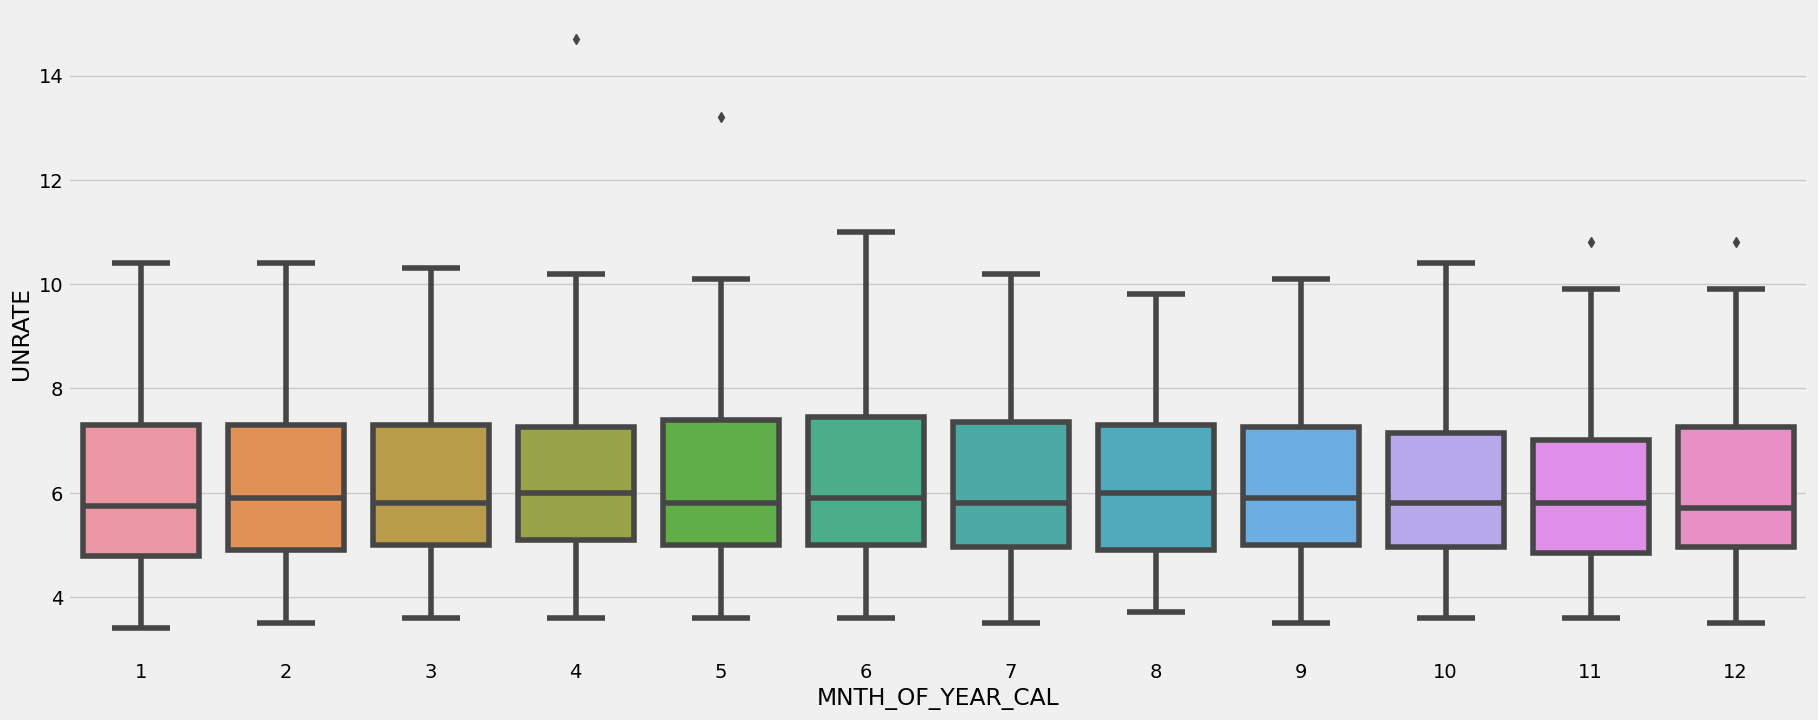

In [132]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title = ('TARGET by month in half')
sns.boxplot(
    data=df,
    x='MNTH_OF_YEAR_CAL',
    y=TARGET,
)

In [89]:
# stop

## **Forecast horizon + Train / Test split**


#### **Define forecast time horizon variables**

In [90]:
import datetime as dt

months_fwd_fc_horizon = 48

today = dt.date.today()
first_of_next_month = today.replace(day=1, month=today.month+1)
if first_of_next_month.month == 1:
    first_of_next_month = first_of_next_month.replace(year=first_of_next_month.year+1)

fc_start_date_str = first_of_next_month
# fc_start_date_str = ''
fc_start_date = pd.Timestamp(fc_start_date_str)
fc_end_date = fc_start_date + pd.DateOffset(months=months_fwd_fc_horizon) # USER INPUT
fc_date_range = pd.date_range(start=fc_start_date, end=fc_end_date, freq='MS') # month start frequency
    # reference this link for frequency charts:
        # https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases

## **Train / Test Split**

In [91]:
test_train_split_date = fc_start_date - pd.DateOffset(months=256)  # USER INPUT variable of split date

df_train = df.loc[df.index < test_train_split_date]
df_test = df.loc[df.index >= test_train_split_date]

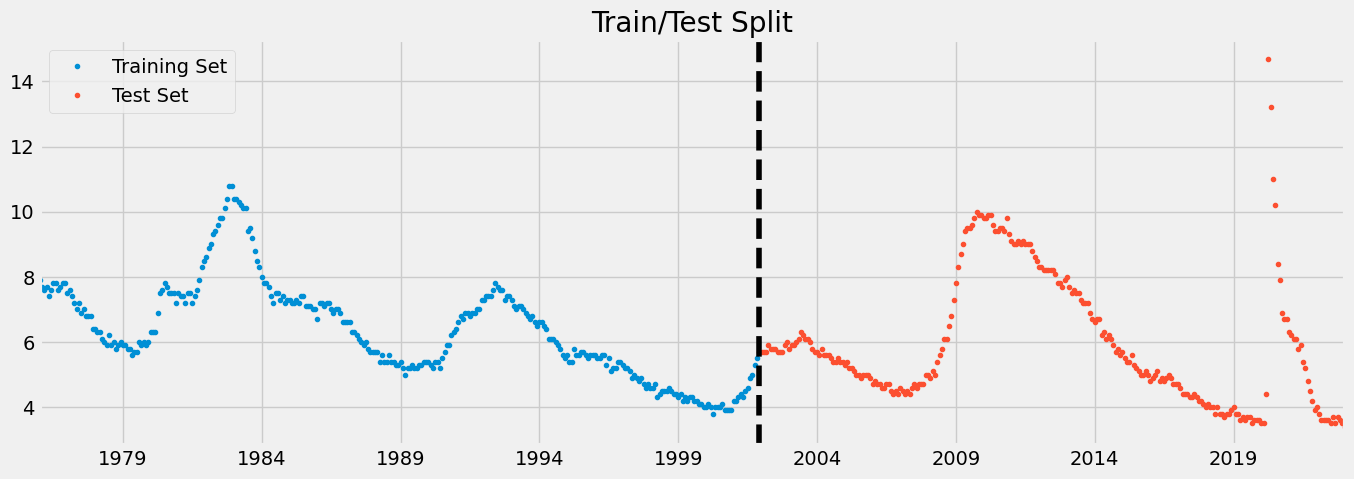

In [92]:
fig, ax = plt.subplots(figsize=(15, 5))
df_train[TARGET].plot(
    ax=ax, style='.', label='Training Set', title='Train/Test Split')
df_test[TARGET].plot(ax=ax, style='.', label='Test Set')
ax.axvline(test_train_split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## **Experiments with creating test models**

In [93]:
# convert columns to proper datatypes for ML learning

# df_train = convert_columns_for_ml(df_train)
# df_test = convert_columns_for_ml(df_test)

In [94]:
X_train = df_train[FEATURES]
y_train = df_train[TARGET]

X_test = df_test[FEATURES]
y_test = df_test[TARGET]

### **Hyperparameter Optimization WIP**

In [95]:
# # preprocessing for hyperparameter tuning
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)

# %%
# # import packages for hyperparameters tuning
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
# from sklearn.metrics import accuracy_score

# #initialize the domain space for hyperparameters to be optimized
# space={
#         'n_estimators': 100,
#         'max_depth': hp.quniform('max_depth', 3, 12, 1),
#         # 'gamma': hp.uniform ('gamma', 0.2,5),
#         # 'reg_alpha' : hp.quniform('reg_alpha', 0.001, 0.1, 1),
#         # 'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         # 'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         # 'min_child_weight' : hp.quniform('min_child_weight', 1, 8, 1),
#         'seed': 0,
#     }

# def objective(space):
#     clf=xgb.XGBClassifier(
#                     n_estimators =space['n_estimators'],
#                     max_depth = int(space['max_depth']),
#                     # gamma = space['gamma'],
#                     # reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
#                     # colsample_bytree=int(space['colsample_bytree'])
#                     )

#     evaluation = [( X_train, y_train), ( X_test, y_test)]

#     clf.fit(X_train, y_train,
#             eval_set=evaluation, eval_metric="auc",
#             early_stopping_rounds=10,verbose=False)


#     pred = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, pred>0.5)
#     print ("SCORE:", accuracy)
#     return {'loss': -accuracy, 'status': STATUS_OK }

# %%
# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

# %%
# print("The best hyperparameters are : ","\n")
# print(best_hyperparams)


### **Train/Test Proof**

In [96]:
# Save final, optimized hyper parameters for training final model here
reg = xgb.XGBRegressor(
    booster='gbtree',
    objective='reg:squarederror',
    base_score=0.5,
    n_estimators=10000,  # tuned
    # n_estimators=20,  # tuned
    min_child_weight=3,
    gamma=0,
    learning_rate=0.01,  # tuned
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=12,
)

reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=2000,
)

[0]	validation_0-rmse:5.99769	validation_1-rmse:5.78629
[2000]	validation_0-rmse:0.00121	validation_1-rmse:0.54707
[4000]	validation_0-rmse:0.00048	validation_1-rmse:0.54824
[6000]	validation_0-rmse:0.00047	validation_1-rmse:0.54828
[8000]	validation_0-rmse:0.00046	validation_1-rmse:0.54828
[9999]	validation_0-rmse:0.00046	validation_1-rmse:0.54826


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

**Our model is now trained**

<br><br><br>


## **Feature Importance**

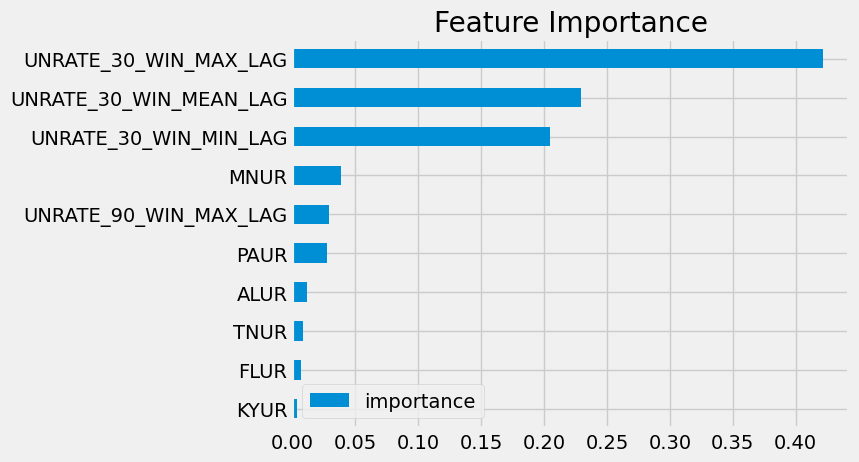

In [97]:
df_fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=['importance']
)
df_fi.sort_values('importance').tail(10).plot(kind='barh', title='Feature Importance')
plt.show()

## **Test forecast on the test set**

In [98]:
df_test['PREDICTION'] = reg.predict(X_test)
df_test['PREDICTION'] = df_test['PREDICTION'].apply(
    lambda x: 0 if x < 0 else x)  # controlling for negative predictions

df_test = df_test.filter(like='PREDICTION')

In [99]:
df_test = pd.merge(
    df,
    df_test,
    left_index = True,
    right_index = True,
    how='left',
)
df_test.tail()

,CAUR,TXUR,NYUR,FLUR,PAUR,OHUR,ALUR,MIUR,WIUR,COUR,...,UNRATE_90_WIN_MEAN_LAG,UNRATE_90_WIN_MIN_LAG,UNRATE_90_WIN_MAX_LAG,UNRATE_90_WIN_STD_LAG,UNRATE_180_WIN_MEAN_LAG,UNRATE_180_WIN_MIN_LAG,UNRATE_180_WIN_MAX_LAG,UNRATE_180_WIN_STD_LAG,UNRATE,PREDICTION
1976-01-01,9.2,5.8,10.3,9.7,8.1,8.1,6.6,9.9,5.8,5.7,...,7.900000,7.9,7.9,NaN,7.900000,7.9,7.9,NaN,7.9,NaN
1976-02-01,9.1,5.9,10.2,9.6,8.1,8.1,6.6,9.9,5.7,5.7,...,7.800000,7.7,7.9,0.141421,7.800000,7.7,7.9,0.141421,7.7,NaN
1976-03-01,9.1,5.9,10.2,9.5,8.1,8.0,6.5,9.8,5.6,5.6,...,7.733333,7.6,7.9,0.152753,7.733333,7.6,7.9,0.152753,7.6,NaN
1976-04-01,9.0,5.9,10.1,9.3,8.1,7.8,6.4,9.6,5.5,5.6,...,7.666667,7.6,7.7,0.057735,7.725000,7.6,7.9,0.125831,7.7,NaN
1976-05-01,9.0,5.9,10.2,9.2,8.0,7.6,6.5,9.4,5.4,5.6,...,7.566667,7.4,7.7,0.152753,7.660000,7.4,7.9,0.181659,7.4,NaN


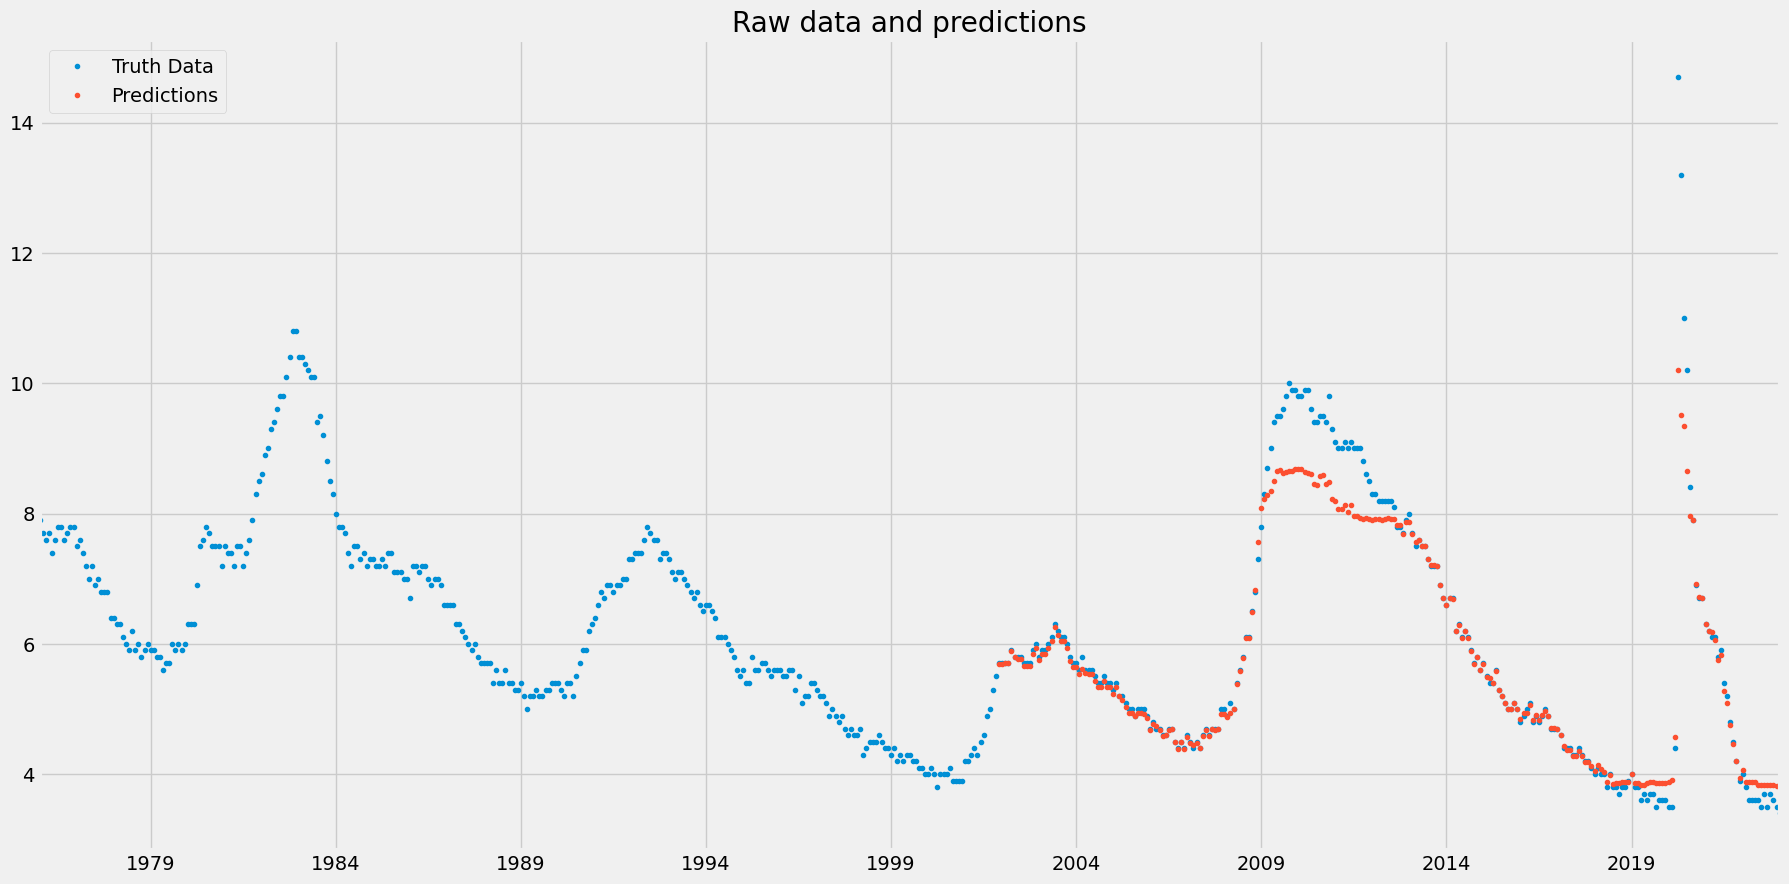

In [100]:
ax = df_test[TARGET].plot(figsize=(20, 10), style='.')
df_test['PREDICTION'].plot(
    ax=ax,
    style='.'
)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw data and predictions')
plt.show()

## **Calculate root mean squared error**

In [101]:
df_test = df_test.loc[df_test.index >= test_train_split_date]
score = np.sqrt(mean_squared_error(
    df_test[TARGET], df_test['PREDICTION']))
stdev = df_test[TARGET].std()
normalized_score = score / stdev
print(f'RMSE Score on Test set: {score:0.6f}')
print(f'RMSE / StdDev on Test set: {normalized_score:0.6f}')

RMSE Score on Test set: 0.548258
RMSE / StdDev on Test set: 0.276262


## **Calculate Nominal Error**

- Look at the worst and best predicted weeks

In [102]:
df_test['abs_error'] = np.abs(df_test[TARGET] - df_test['PREDICTION'])
df_test['error'] = df_test[TARGET] - df_test['PREDICTION']

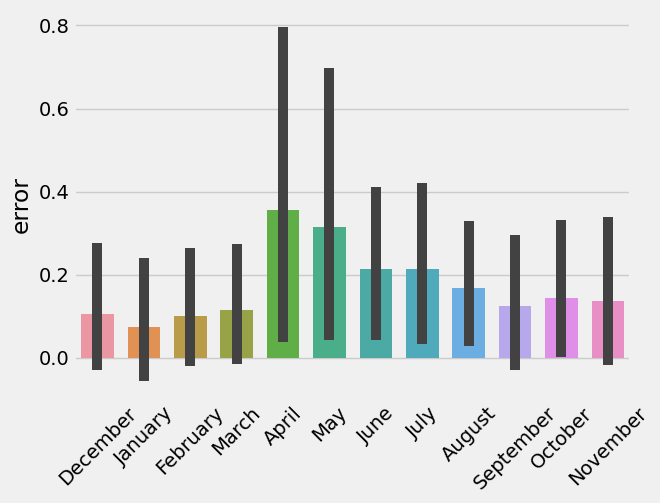

In [103]:
df_test_monthly = df_test.resample('M').sum()

# Create a bar chart using seaborn
sns.barplot(
    x=df_test_monthly.index.strftime('%B'), 
    y='error', 
    data=df_test_monthly,  
    width=0.7, 
    )

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show plot
plt.show()


In [104]:
# df_test.to_clipboard(excel=True, index=False, header=True

In [ ]:
# stop

<br><br><br><br><br><br>

## **Predicting into the future**

1. Retrain fresh model on all data
2. create forecast / future dataframe to hang our predictions on
3. predict the future
    1. look into the crystal ball

In [ ]:
X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(
    booster='gbtree',
    # objective = 'reg:linear',
    objective='reg:squarederror',
    base_score=0.5,
    n_estimators=200000,  # tuned
    # n_estimators = 1000,
    learning_rate=0.0001,  # tuned
    # learning_rate = 0.042,
    max_depth=32,  # tuned
    # max_depth = 6,
)
reg.fit(
    X_all,
    y_all,
    eval_set=[(X_all, y_all)],
    verbose=10000,
)

### **Create Forecast (fc_) dataframe for predictions**

- replicate dimensionality of the rear window forecast range
    - defined by user

In [ ]:
# create add forecast (_fc) time range to main df
df_fc = pd.DataFrame(index=fc_date_range,)

def create_df_fc (
    df_left,
    df_right):
    # list of columns to merge
    # cols_to_merge = [df_left.index, ]
    df_left['index'] = df_left.index
    # create a new dataframe by merging the selected columns with NaN-filled columns
    merged_df = pd.concat([df_left['index'], df_right], axis=1)
    merged_df = merged_df.drop(['index'], axis=1)
    # print(merged_df)

    return merged_df

df = create_df_fc(
    df_fc,
    df
)


In [ ]:
fc_start_date = pd.to_datetime(fc_start_date_str)
# split out `df_fc` into its own named object
df_fc = df.query(f'index > "{fc_start_date.strftime("%Y-%m-%d")}"')

In [ ]:
# stop

<br><br><br>

### **Predict the future**

In [ ]:
# df_fc = convert_columns_for_ml(df_fc)
df_fc['PREDICTION'] = reg.predict(df_fc[FEATURES])

In [ ]:
# plot the future
df_fc['PREDICTION'].plot(
    figsize=(10, 5),
    style='--',
    color=color_pal[5],
    ms=1,
    lw=1, title='Future Predictions'
)
plt.show()

## **Saving Model for Later**

In [ ]:
# reg.save_model('model.json')

### **Loading it back up for validation**


In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
# predict the future
df_fc['PREDICTION'] = reg.predict(df_fc[FEATURES])
# plot the future
df_fc['PREDICTION'].plot(
    figsize=(10, 5),
    style='.',
    color=color_pal[5],
    ms=1,
    lw=1, title='Future Predictions'
)

In [ ]:
df_fc.to_clipboard(excel=True, index=False, header=True)

In [ ]:
# stop